### Mechanistic Free Energy Principle Model of General Suicidal Thoughts

<img src="fig/Fig1.png" width="800">

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helper import log_stable, softmax, kl_divergence, create_likelihood_matrix, get_prior, plot_likelihood, plot_belief

def inference(likelihood, prior, obs):
    qs = infer_states(obs, likelihood, prior)
    dkl = kl_divergence(qs, likelihood[obs, :])
    evidence = log_stable(prior)
    F = dkl - evidence
    return qs, F

# Get approximate posterior
def infer_states(observation_index, likelihood_matrix, prior):
    log_likelihood = log_stable(likelihood_matrix[observation_index, :])
    log_prior = log_stable(prior)
    qs = softmax(log_likelihood + log_prior)
    return qs

def perturbation(F_ext1, weight1, F_ext2, weight2, F_array, obs):
    F = F_array[obs] + (weight1 * F_ext1) + (weight2 * F_ext2)
    idx = (np.abs(F_array - F)).argmin()
    return idx, F

def step(likelihood, prior, obs, F_ext1, w1, F_ext2, w2):
    qs, F = inference(likelihood, prior, obs)
    qs2, F2 = perturbation(F_ext1, w1, F_ext2, w2, F, obs)
    return qs, F, qs2, F2

def collect(Fs, Fi, Fd):
    Fp = w_sp * Fs + w_ip * Fi + w_dp * Fd
    return Fp

def impulse(v_rec, t_rec, s_rec, v, theta, dt, tau, el,i, t):
    s = v > theta
    v = s* el + (1-s) * (v - dt/ tau * ((v - el) - i))
    v_rec = np.append(v_rec, v)
    t_rec = np.append(t_rec, t)
    s_rec = np.append(s_rec, s)
    return s,v,v_rec,t_rec,s_rec

sizes, sizei, sized, sizep = [50, 50, 50, 8]
decays1, decays2, decayi1, decayi2, decayd1, decayd2, decayp1, decayp2 = [2, 1, 2, 0.8, 2, 0.5, 2, 1]
w_si, w_sd, w_sp, w_id, w_ip, w_dp = [0.5, 0.1, 0.9, 0.2, 0.8, 0.7]

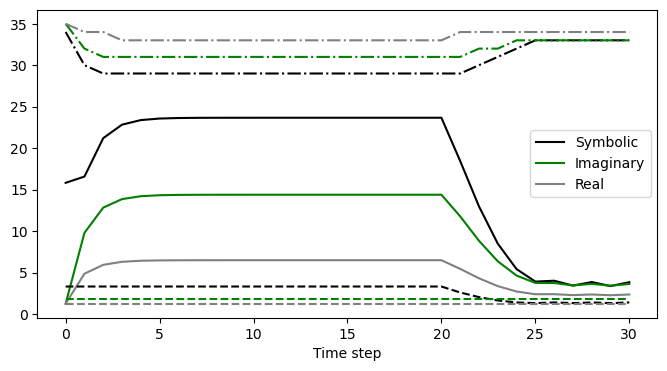

In [2]:
likelihood_s = create_likelihood_matrix(sizes, decays1)
prior_s = get_prior(25, sizes, decays2)

likelihood_i = create_likelihood_matrix(sizei, decayi1)
prior_i = get_prior(25, sizei, decayi2)

likelihood_d = create_likelihood_matrix(sized, decayd1)
prior_d = get_prior(25, sized, decayd2)

obs_s, obs_i, obs_d = [20,25, 25]

Fss_history, Fii_history, Fdd_history = [], [], []
Fs_min_history, Fi_min_history, Fd_min_history = [], [], []
qss_history, qsi_history, qsd_history = [], [], []

qss, Fs = inference(likelihood_s, prior_s, obs_s)
Fss = Fs[obs_s]
Fss_history.append(Fss)
Fs_min = Fs[Fs.argmin()]
Fs_min_history.append(Fs_min)
qss_history.append(qss.argmax())

qsi, Fi = inference(likelihood_i, prior_i, obs_i)
qsi_history.append(qsi.argmax())
Fii = Fi[obs_i]
Fii_history.append(Fii)
Fi_min = Fi[Fi.argmin()]
Fi_min_history.append(Fi_min)

qsd, Fd = inference(likelihood_d, prior_d, obs_d)
qsd_history.append(qsd.argmax())
Fdd = Fd[obs_d]
Fdd_history.append(Fdd)
Fd_min = Fd[Fd.argmin()]
Fd_min_history.append(Fd_min)


for _ in range(20):
    qss, Fs, qsss, Fss = step(likelihood_s, prior_s, obs_s, Fii, w_si, Fdd, w_sd)
    Fss_history.append(Fss)
    Fs_min_history.append(Fs.min())
    qss_history.append(qsss)  # Assuming qsss is the updated posterior

    qsi, Fi, qsii, Fii = step(likelihood_i, prior_i, obs_i, Fss, w_si, Fdd, w_id)
    Fii_history.append(Fii)
    Fi_min_history.append(Fi.min())
    qsi_history.append(qsii)

    qsd, Fd, qsdd, Fdd = step(likelihood_d, prior_d, obs_d, Fss, w_sd, Fii, w_id)
    Fdd_history.append(Fdd)
    Fd_min_history.append(Fd.min())
    qsd_history.append(qsdd)

for _ in range(10):
    if obs_s < 26:
        obs_s += 1
    else:
        obs_s =25
        
    qss, Fs, qsss, Fss = step(likelihood_s, prior_s, obs_s, Fii, w_si, Fdd, w_sd)
    Fss_history.append(Fss)
    Fs_min_history.append(Fs.min())
    qss_history.append(qsss)  # Assuming qsss is the updated posterior

    qsi, Fi, qsii, Fii = step(likelihood_i, prior_i, obs_i, Fss, w_si, Fdd, w_id)
    Fii_history.append(Fii)
    Fi_min_history.append(Fi.min())
    qsi_history.append(qsii)

    qsd, Fd, qsdd, Fdd = step(likelihood_d, prior_d, obs_d, Fss, w_sd, Fii, w_id)
    Fdd_history.append(Fdd)
    Fd_min_history.append(Fd.min())
    qsd_history.append(qsdd)
    

Fi_min_history1 = [x + 0.6 for x in Fi_min_history]
qss_history1 = [x + 10 for x in qss_history]
qsi_history1 = [x + 10 for x in qsi_history]
qsd_history1 = [x + 10 for x in qsd_history]

plt.figure(figsize=(8, 4))

plt.plot(Fss_history, label='Symbolic', linestyle='-', color='black')
plt.plot(Fii_history, label='Imaginary', linestyle='-', color='green')
plt.plot(Fdd_history, label='Real', linestyle='-', color='gray')
plt.legend()
plt.plot(Fs_min_history, linestyle='--', color='black')
plt.plot(Fi_min_history1, linestyle='--', color='green')
plt.plot(Fd_min_history, linestyle='--', color='gray')
plt.plot(qss_history1, linestyle='-.', color='black')
plt.plot(qsi_history1, linestyle='-.', color='green')
plt.plot(qsd_history1, linestyle='-.', color='gray')

plt.xlabel('Time step')
plt.show()

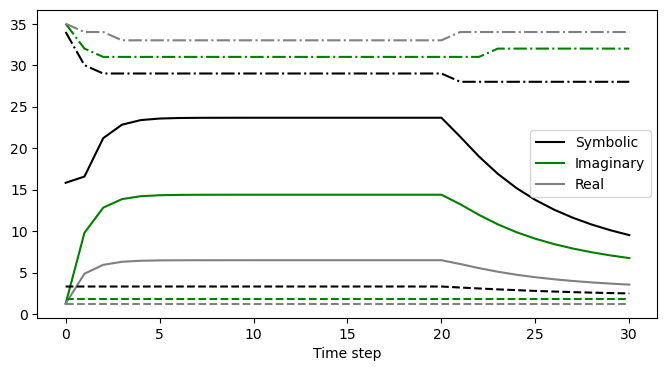

In [3]:
likelihood_s = create_likelihood_matrix(sizes, decays1)
prior_s = get_prior(25, sizes, decays2)
decayss = decays2

likelihood_i = create_likelihood_matrix(sizei, decayi1)
prior_i = get_prior(25, sizei, decayi2)

likelihood_d = create_likelihood_matrix(sized, decayd1)
prior_d = get_prior(25, sized, decayd2)

obs_s, obs_i, obs_d = [20,25, 25]

Fss_history, Fii_history, Fdd_history = [], [], []
Fs_min_history, Fi_min_history, Fd_min_history = [], [], []
qss_history, qsi_history, qsd_history = [], [], []

qss, Fs = inference(likelihood_s, prior_s, obs_s)
Fss = Fs[obs_s]
Fss_history.append(Fss)
Fs_min = Fs[Fs.argmin()]
Fs_min_history.append(Fs_min)
qss_history.append(qss.argmax())

qsi, Fi = inference(likelihood_i, prior_i, obs_i)
qsi_history.append(qsi.argmax())
Fii = Fi[obs_i]
Fii_history.append(Fii)
Fi_min = Fi[Fi.argmin()]
Fi_min_history.append(Fi_min)

qsd, Fd = inference(likelihood_d, prior_d, obs_d)
qsd_history.append(qsd.argmax())
Fdd = Fd[obs_d]
Fdd_history.append(Fdd)
Fd_min = Fd[Fd.argmin()]
Fd_min_history.append(Fd_min)


for _ in range(20):
    qss, Fs, qsss, Fss = step(likelihood_s, prior_s, obs_s, Fii, w_si, Fdd, w_sd)
    Fss_history.append(Fss)
    Fs_min_history.append(Fs.min())
    qss_history.append(qsss)  # Assuming qsss is the updated posterior

    qsi, Fi, qsii, Fii = step(likelihood_i, prior_i, obs_i, Fss, w_si, Fdd, w_id)
    Fii_history.append(Fii)
    Fi_min_history.append(Fi.min())
    qsi_history.append(qsii)

    qsd, Fd, qsdd, Fdd = step(likelihood_d, prior_d, obs_d, Fss, w_sd, Fii, w_id)
    Fdd_history.append(Fdd)
    Fd_min_history.append(Fd.min())
    qsd_history.append(qsdd)

for _ in range(10):
    
    decayss += 0.1
    prior_ss = get_prior(25, sizes, decayss)
        
    qss, Fs, qsss, Fss = step(likelihood_s, prior_ss, obs_s, Fii, w_si, Fdd, w_sd)
    Fss_history.append(Fss)
    Fs_min_history.append(Fs.min())
    qss_history.append(qsss)  # Assuming qsss is the updated posterior

    qsi, Fi, qsii, Fii = step(likelihood_i, prior_i, obs_i, Fss, w_si, Fdd, w_id)
    Fii_history.append(Fii)
    Fi_min_history.append(Fi.min())
    qsi_history.append(qsii)

    qsd, Fd, qsdd, Fdd = step(likelihood_d, prior_d, obs_d, Fss, w_sd, Fii, w_id)
    Fdd_history.append(Fdd)
    Fd_min_history.append(Fd.min())
    qsd_history.append(qsdd)
    

Fi_min_history1 = [x + 0.6 for x in Fi_min_history]
qss_history1 = [x + 10 for x in qss_history]
qsi_history1 = [x + 10 for x in qsi_history]
qsd_history1 = [x + 10 for x in qsd_history]

plt.figure(figsize=(8, 4))

plt.plot(Fss_history, label='Symbolic', linestyle='-', color='black')
plt.plot(Fii_history, label='Imaginary', linestyle='-', color='green')
plt.plot(Fdd_history, label='Real', linestyle='-', color='gray')
plt.legend()
plt.plot(Fs_min_history, linestyle='--', color='black')
plt.plot(Fi_min_history1, linestyle='--', color='green')
plt.plot(Fd_min_history, linestyle='--', color='gray')
plt.plot(qss_history1, linestyle='-.', color='black')
plt.plot(qsi_history1, linestyle='-.', color='green')
plt.plot(qsd_history1, linestyle='-.', color='gray')

plt.xlabel('Time step')
plt.show()

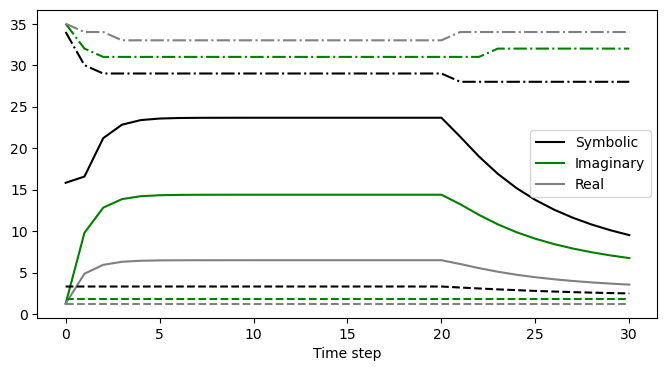

In [4]:
likelihood_s = create_likelihood_matrix(sizes, decays1)
prior_s = get_prior(25, sizes, decays2)
decayss = decays2

likelihood_i = create_likelihood_matrix(sizei, decayi1)
prior_i = get_prior(25, sizei, decayi2)

likelihood_d = create_likelihood_matrix(sized, decayd1)
prior_d = get_prior(25, sized, decayd2)

obs_s, obs_i, obs_d = [20,25, 25]

Fss_history, Fii_history, Fdd_history = [], [], []
Fs_min_history, Fi_min_history, Fd_min_history = [], [], []
qss_history, qsi_history, qsd_history = [], [], []

qss, Fs = inference(likelihood_s, prior_s, obs_s)
Fss = Fs[obs_s]
Fss_history.append(Fss)
Fs_min = Fs[Fs.argmin()]
Fs_min_history.append(Fs_min)
qss_history.append(qss.argmax())

qsi, Fi = inference(likelihood_i, prior_i, obs_i)
qsi_history.append(qsi.argmax())
Fii = Fi[obs_i]
Fii_history.append(Fii)
Fi_min = Fi[Fi.argmin()]
Fi_min_history.append(Fi_min)

qsd, Fd = inference(likelihood_d, prior_d, obs_d)
qsd_history.append(qsd.argmax())
Fdd = Fd[obs_d]
Fdd_history.append(Fdd)
Fd_min = Fd[Fd.argmin()]
Fd_min_history.append(Fd_min)


for _ in range(20):
    qss, Fs, qsss, Fss = step(likelihood_s, prior_s, obs_s, Fii, w_si, Fdd, w_sd)
    Fss_history.append(Fss)
    Fs_min_history.append(Fs.min())
    qss_history.append(qsss)  # Assuming qsss is the updated posterior

    qsi, Fi, qsii, Fii = step(likelihood_i, prior_i, obs_i, Fss, w_si, Fdd, w_id)
    Fii_history.append(Fii)
    Fi_min_history.append(Fi.min())
    qsi_history.append(qsii)

    qsd, Fd, qsdd, Fdd = step(likelihood_d, prior_d, obs_d, Fss, w_sd, Fii, w_id)
    Fdd_history.append(Fdd)
    Fd_min_history.append(Fd.min())
    qsd_history.append(qsdd)

for _ in range(10):
    
    decayss += 0.1
    prior_ss = get_prior(25, sizes, decayss)
        
    qss, Fs, qsss, Fss = step(likelihood_s, prior_ss, obs_s, Fii, w_si, Fdd, w_sd)
    Fss_history.append(Fss)
    Fs_min_history.append(Fs.min())
    qss_history.append(qsss)  # Assuming qsss is the updated posterior

    qsi, Fi, qsii, Fii = step(likelihood_i, prior_i, obs_i, Fss, w_si, Fdd, w_id)
    Fii_history.append(Fii)
    Fi_min_history.append(Fi.min())
    qsi_history.append(qsii)

    qsd, Fd, qsdd, Fdd = step(likelihood_d, prior_d, obs_d, Fss, w_sd, Fii, w_id)
    Fdd_history.append(Fdd)
    Fd_min_history.append(Fd.min())
    qsd_history.append(qsdd)
    

Fi_min_history1 = [x + 0.6 for x in Fi_min_history]
qss_history1 = [x + 10 for x in qss_history]
qsi_history1 = [x + 10 for x in qsi_history]
qsd_history1 = [x + 10 for x in qsd_history]

plt.figure(figsize=(8, 4))

plt.plot(Fss_history, label='Symbolic', linestyle='-', color='black')
plt.plot(Fii_history, label='Imaginary', linestyle='-', color='green')
plt.plot(Fdd_history, label='Real', linestyle='-', color='gray')
plt.legend()
plt.plot(Fs_min_history, linestyle='--', color='black')
plt.plot(Fi_min_history1, linestyle='--', color='green')
plt.plot(Fd_min_history, linestyle='--', color='gray')
plt.plot(qss_history1, linestyle='-.', color='black')
plt.plot(qsi_history1, linestyle='-.', color='green')
plt.plot(qsd_history1, linestyle='-.', color='gray')

plt.xlabel('Time step')
plt.show()

C:\Users\lilin\AppData\Local\Temp\ipykernel_41608\13907839.py:90: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0])
C:\Users\lilin\AppData\Local\Temp\ipykernel_41608\13907839.py:104: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot(gs[2])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


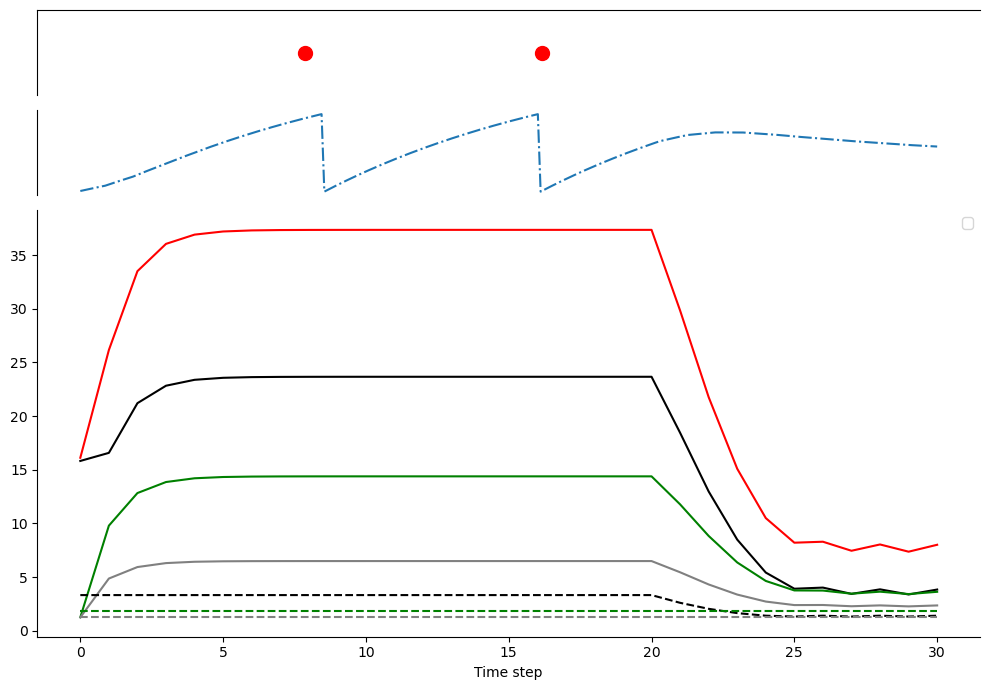

In [5]:
likelihood_s, likelihood_i, likelihood_d = create_likelihood_matrix(sizes, decays1), create_likelihood_matrix(sizei, decayi1), create_likelihood_matrix(sized, decayd1)
prior_s, prior_i, prior_d = get_prior(25, sizes, decays2), get_prior(25, sizei, decayi2), get_prior(25, sized, decayd2)
obs_s, obs_i, obs_d = [20,25, 25]
dt, tau, el, theta, t_step = 0.1, 10, 0, 20, 0
Fss_history, Fii_history, Fdd_history, Fp_history = [], [], [], []
Fs_min_history, Fi_min_history, Fd_min_history = [], [], []
qss_history, qsi_history, qsd_history = [], [], []
v_rec, t_rec, s_rec = np.array([]), np.array([]), np.array([])

qss, Fs = inference(likelihood_s, prior_s, obs_s)
Fss = Fs[obs_s]
Fss_history.append(Fss)
Fs_min = Fs[Fs.argmin()]
Fs_min_history.append(Fs_min)
qss_history.append(qss.argmax())

qsi, Fi = inference(likelihood_i, prior_i, obs_i)
qsi_history.append(qsi.argmax())
Fii = Fi[obs_i]
Fii_history.append(Fii)
Fi_min = Fi[Fi.argmin()]
Fi_min_history.append(Fi_min)

qsd, Fd = inference(likelihood_d, prior_d, obs_d)
qsd_history.append(qsd.argmax())
Fdd = Fd[obs_d]
Fdd_history.append(Fdd)
Fd_min = Fd[Fd.argmin()]
Fd_min_history.append(Fd_min)

a, b, c, d, v, dt, T = 0.05, 2, 0.5, 20, 0, 0.1, 20
u = b * v
Fp = collect(Fss, Fii, Fdd)
Fp_history.append(Fp)

v = el
for t in range (int(1/dt)):
    s, v, v_rec, t_rec, s_rec = impulse(v_rec, t_rec, s_rec, v, theta, dt, tau, el, Fp, t)

for _ in range(20):
    qss, Fs, qsss, Fss = step(likelihood_s, prior_s, obs_s, Fii, w_si, Fdd, w_sd)
    Fss_history.append(Fss)
    Fs_min_history.append(Fs.min())
    qss_history.append(qsss)  # Assuming qsss is the updated posterior

    qsi, Fi, qsii, Fii = step(likelihood_i, prior_i, obs_i, Fss, w_si, Fdd, w_id)
    Fii_history.append(Fii)
    Fi_min_history.append(Fi.min())
    qsi_history.append(qsii)

    qsd, Fd, qsdd, Fdd = step(likelihood_d, prior_d, obs_d, Fss, w_sd, Fii, w_id)
    Fdd_history.append(Fdd)
    Fd_min_history.append(Fd.min())
    qsd_history.append(qsdd)
    Fp = collect(Fss, Fii, Fdd)
    Fp_history.append(Fp)

    for t in range (int(1/dt)):
        s, v, v_rec, t_rec, s_rec = impulse(v_rec, t_rec, s_rec, v, theta, dt, tau, el, Fp, t)

for _ in range(10):
    if obs_s < 26:
        obs_s += 1
    else:
        obs_s =25
        
    qss, Fs, qsss, Fss = step(likelihood_s, prior_s, obs_s, Fii, w_si, Fdd, w_sd)
    Fss_history.append(Fss)
    Fs_min_history.append(Fs.min())
    qss_history.append(qsss)  # Assuming qsss is the updated posterior

    qsi, Fi, qsii, Fii = step(likelihood_i, prior_i, obs_i, Fss, w_si, Fdd, w_id)
    Fii_history.append(Fii)
    Fi_min_history.append(Fi.min())
    qsi_history.append(qsii)

    qsd, Fd, qsdd, Fdd = step(likelihood_d, prior_d, obs_d, Fss, w_sd, Fii, w_id)
    Fdd_history.append(Fdd)
    Fd_min_history.append(Fd.min())
    qsd_history.append(qsdd)
    Fp = collect(Fss, Fii, Fdd)
    Fp_history.append(Fp)
    for t in range (int(1/dt)):
        s, v, v_rec, t_rec, s_rec = impulse(v_rec, t_rec, s_rec, v, theta, dt, tau, el, Fp, t)
    
Fi_min_history1 = [x + 0.6 for x in Fi_min_history]
import matplotlib.gridspec as gridspec
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 7))
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,5])
ax1 = plt.subplot(gs[0])
ax1.plot(s_rec, '.', markersize=20, color = 'red')
ax1.axis([0, 31/dt, 0.8, 1.2])
plt.xticks([], [])
plt.yticks([], [])
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2 = plt.subplot(gs[1])
ax2.plot(v_rec, linestyle = '-.')
plt.xticks([], [])
plt.yticks([], [])
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3 = plt.subplot(gs[2])
ax3.plot(Fss_history, linestyle='-', color='black')
ax3.plot(Fii_history, linestyle='-', color='green')
ax3.plot(Fdd_history, linestyle='-', color='gray')
ax3.plot(Fp_history, linestyle='-', color='red')
ax3.plot(Fs_min_history, linestyle='--', color='black')
ax3.plot(Fi_min_history1, linestyle='--', color='green')
ax3.plot(Fd_min_history, linestyle='--', color='gray')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.legend()
ax3.set_xlabel('Time step')
plt.tight_layout()
plt.show()

C:\Users\lilin\AppData\Local\Temp\ipykernel_41608\2155451237.py:89: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0])
C:\Users\lilin\AppData\Local\Temp\ipykernel_41608\2155451237.py:103: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax3 = plt.subplot(gs[2])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


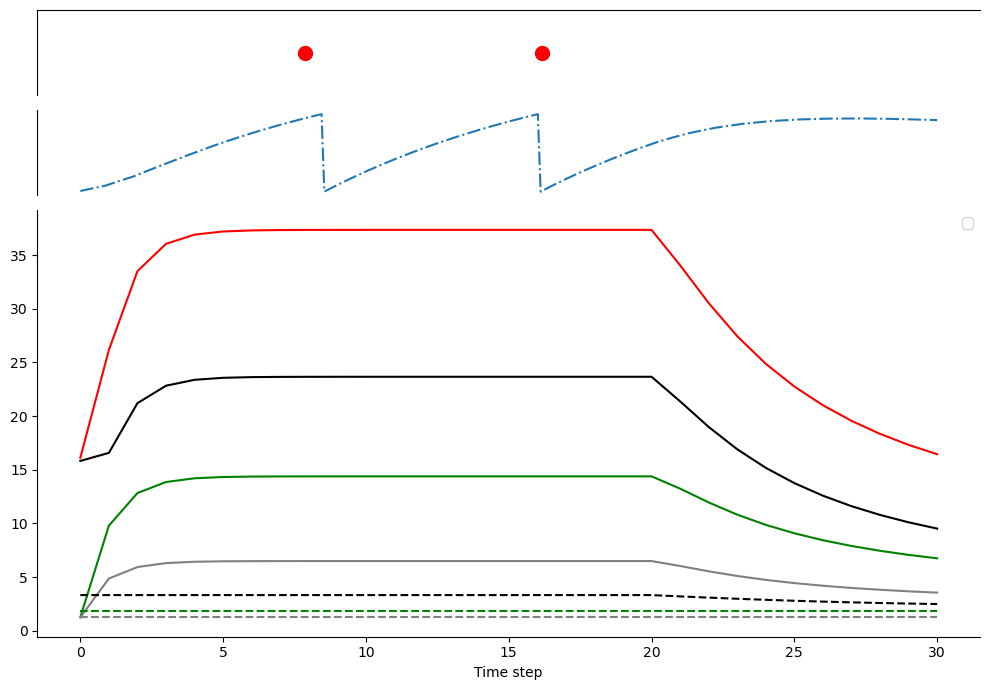

In [6]:
likelihood_s, likelihood_i, likelihood_d = create_likelihood_matrix(sizes, decays1), create_likelihood_matrix(sizei, decayi1), create_likelihood_matrix(sized, decayd1)
prior_s, prior_i, prior_d = get_prior(25, sizes, decays2), get_prior(25, sizei, decayi2), get_prior(25, sized, decayd2)
decayss = decays2
obs_s, obs_i, obs_d = [20,25, 25]
dt, tau, el, theta, t_step = 0.1, 10, 0, 20, 0
Fss_history, Fii_history, Fdd_history, Fp_history = [], [], [], []
Fs_min_history, Fi_min_history, Fd_min_history = [], [], []
qss_history, qsi_history, qsd_history = [], [], []
v_rec, t_rec, s_rec = np.array([]), np.array([]), np.array([])

qss, Fs = inference(likelihood_s, prior_s, obs_s)
Fss = Fs[obs_s]
Fss_history.append(Fss)
Fs_min = Fs[Fs.argmin()]
Fs_min_history.append(Fs_min)
qss_history.append(qss.argmax())

qsi, Fi = inference(likelihood_i, prior_i, obs_i)
qsi_history.append(qsi.argmax())
Fii = Fi[obs_i]
Fii_history.append(Fii)
Fi_min = Fi[Fi.argmin()]
Fi_min_history.append(Fi_min)

qsd, Fd = inference(likelihood_d, prior_d, obs_d)
qsd_history.append(qsd.argmax())
Fdd = Fd[obs_d]
Fdd_history.append(Fdd)
Fd_min = Fd[Fd.argmin()]
Fd_min_history.append(Fd_min)

a, b, c, d, v, dt, T = 0.05, 2, 0.5, 20, 0, 0.1, 20
u = b * v
Fp = collect(Fss, Fii, Fdd)
Fp_history.append(Fp)

v = el
for t in range (int(1/dt)):
    s, v, v_rec, t_rec, s_rec = impulse(v_rec, t_rec, s_rec, v, theta, dt, tau, el, Fp, t)

for _ in range(20):
    qss, Fs, qsss, Fss = step(likelihood_s, prior_s, obs_s, Fii, w_si, Fdd, w_sd)
    Fss_history.append(Fss)
    Fs_min_history.append(Fs.min())
    qss_history.append(qsss)  # Assuming qsss is the updated posterior

    qsi, Fi, qsii, Fii = step(likelihood_i, prior_i, obs_i, Fss, w_si, Fdd, w_id)
    Fii_history.append(Fii)
    Fi_min_history.append(Fi.min())
    qsi_history.append(qsii)

    qsd, Fd, qsdd, Fdd = step(likelihood_d, prior_d, obs_d, Fss, w_sd, Fii, w_id)
    Fdd_history.append(Fdd)
    Fd_min_history.append(Fd.min())
    qsd_history.append(qsdd)
    Fp = collect(Fss, Fii, Fdd)
    Fp_history.append(Fp)

    for t in range (int(1/dt)):
        s, v, v_rec, t_rec, s_rec = impulse(v_rec, t_rec, s_rec, v, theta, dt, tau, el, Fp, t)

for _ in range(10):
    decayss += 0.1
    prior_ss = get_prior(25, sizes, decayss)
        
    qss, Fs, qsss, Fss = step(likelihood_s, prior_ss, obs_s, Fii, w_si, Fdd, w_sd)
    Fss_history.append(Fss)
    Fs_min_history.append(Fs.min())
    qss_history.append(qsss)  # Assuming qsss is the updated posterior

    qsi, Fi, qsii, Fii = step(likelihood_i, prior_i, obs_i, Fss, w_si, Fdd, w_id)
    Fii_history.append(Fii)
    Fi_min_history.append(Fi.min())
    qsi_history.append(qsii)

    qsd, Fd, qsdd, Fdd = step(likelihood_d, prior_d, obs_d, Fss, w_sd, Fii, w_id)
    Fdd_history.append(Fdd)
    Fd_min_history.append(Fd.min())
    qsd_history.append(qsdd)
    Fp = collect(Fss, Fii, Fdd)
    Fp_history.append(Fp)
    for t in range (int(1/dt)):
        s, v, v_rec, t_rec, s_rec = impulse(v_rec, t_rec, s_rec, v, theta, dt, tau, el, Fp, t)
    
Fi_min_history1 = [x + 0.6 for x in Fi_min_history]
import matplotlib.gridspec as gridspec
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 7))
gs = gridspec.GridSpec(3, 1, height_ratios=[1,1,5])
ax1 = plt.subplot(gs[0])
ax1.plot(s_rec, '.', markersize=20, color = 'red')
ax1.axis([0, 31/dt, 0.8, 1.2])
plt.xticks([], [])
plt.yticks([], [])
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2 = plt.subplot(gs[1])
ax2.plot(v_rec, linestyle = '-.')
plt.xticks([], [])
plt.yticks([], [])
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3 = plt.subplot(gs[2])
ax3.plot(Fss_history, linestyle='-', color='black')
ax3.plot(Fii_history, linestyle='-', color='green')
ax3.plot(Fdd_history, linestyle='-', color='gray')
ax3.plot(Fp_history, linestyle='-', color='red')
ax3.plot(Fs_min_history, linestyle='--', color='black')
ax3.plot(Fi_min_history1, linestyle='--', color='green')
ax3.plot(Fd_min_history, linestyle='--', color='gray')
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.legend()
ax3.set_xlabel('Time step')
plt.tight_layout()
plt.show()